In [1]:
import os
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import warnings
warnings.filterwarnings('ignore')

In [2]:
class PrepareDatFrame:
    def __init__(self, chat):
        self.chat = chat
        
        
    def get_author(self):
        author = []
        for line in self.chat:
            try:
                if 'AM' in line  or 'PM' in line:
                    author.append(line.split('-')[1].split(':')[0].strip())
            except:
                author.append(np.nan)
        return author
    
    
    def get_message(self):
        message = []
        for line in self.chat:
            try:
                if 'AM' in line  or 'PM' in line:
                    message.append(line.split('-')[1].split(':')[-1].strip())
            except:
                message.append(np.nan)
        return message
    
    
    def get_date(self):
        date = []
        for line in self.chat:
            try:
                if 'AM' in line  or 'PM' in line:
                    date.append(line.split('-')[0].split(',')[0].strip())
            except:
                date.append(np.nan)
        return date
    
    def get_time(self):
        time = []
        for line in self.chat:
            try:
                if 'AM' in line  or 'PM' in line:
                    time.append(line.split('-')[0].split(',')[1].strip())
            except Exception as e:
                time.append(np.nan)
        return time
    
    def get_dataframe(self):
        df = pd.DataFrame()
        df['date'] = self.get_date()
        df['time'] = self.get_time()
        df['author'] = self.get_author()
        df['message'] = self.get_message()
        
        
        df = df.dropna()
        
        df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True).apply(lambda x: x.strftime('%d-%m-%Y'))
        df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True).apply(lambda x: x.strftime('%H:%M'))
        
        return df

In [3]:
class Visualize:
    def __init__(self, chat_df):
        self.chat_df = chat_df
        self.whatsapp_filtered_chat_df = self.chat_df[self.chat_df['author'] != self.chat_df['message']] ## WhatsApp messages filtered
        self.whatsapp_filtered_chat_df['letter_count'] = self.whatsapp_filtered_chat_df['message'].apply(lambda x: len(x.split()))
        
    def num_msgs_exchanged(self):
        print('Number of messages exchanged between {} and {}: {} (roughly)'.format(self.chat_df['date'].iloc[0], self.chat_df['date'].iloc[-1], self.chat_df.shape[0]))
        
    def num_days_since_active(self):
        print('Number of days since Chat/Group active: ', len(self.chat_df['date'].value_counts()))
        
    def mysterious_msgs(self):
        print('Mysterious messages without authors (Messages from WhatsApp itself): ', self.chat_df.shape[0] - self.whatsapp_filtered_chat_df.shape[0])
        
    def plot_data(self):
        
        ## Most talketive
        plt.figure(figsize=(10, 6))
        self.whatsapp_filtered_chat_df['author'].value_counts().plot.barh()
        plt.title('Most talketive')
        
        
        ## Media sent data
        media_messages = self.whatsapp_filtered_chat_df[self.whatsapp_filtered_chat_df['message'] == '<Media omitted>']
        plt.figure(figsize=(10, 6))
        media_messages['author'].value_counts().plot.barh()
        plt.title('People who send the most Media')
        
        
        ## Word count by author
        word_count_by_author = self.whatsapp_filtered_chat_df[['author', 'letter_count']].groupby('author').sum().sort_values('letter_count', ascending=True)
        plt.figure(figsize=(10, 6))
        word_count_by_author.plot.barh()
        plt.title('Number of words sent by each author')

        
        ## Most common number of words
        plt.figure(figsize=(10, 6))
        self.whatsapp_filtered_chat_df['letter_count'].value_counts()[:10].plot.barh()
        plt.title('Most common number of words in messages (Top 10)')
        
        
        ## Date on which most number of messages were sent
        plt.figure(figsize=(10, 6))
        self.whatsapp_filtered_chat_df['date'].value_counts()[:10].plot.barh()
        plt.title('Most messages sent on a particular date (Top 10)')
        
        
        ## Most suitable hour of day
        plt.figure(figsize=(10, 6))
        self.whatsapp_filtered_chat_df['time'].apply(lambda x: str(x).split(':')[0]).value_counts()[:10].plot.barh()
        plt.title('Most suitable time at which the chances of getting a response increases')
        
        
        ## Sentiment
        plt.figure(figsize=(10, 6))
        
        sent = SentimentIntensityAnalyzer()
        scores_dict = self.whatsapp_filtered_chat_df['message'].apply(lambda x: sent.polarity_scores(x))
        for dicts in scores_dict:
            dicts.pop('compound')
        
        sents = []
        for scores in scores_dict:
            sents.append(max(scores, key=lambda k: scores[k]))
        
        
        plt.hist(sents)
        plt.title('Sentiment of messages (Without cleaning text)')
        
        
        
        plt.show()
        
    def analyze(self):
        self.num_days_since_active()
        self.num_msgs_exchanged()
        self.mysterious_msgs()
        self.plot_data()

In [7]:
DATA_DIR = '../../Resources/data/chatbot/'
chat_name = 'M'

with open(os.path.join(DATA_DIR, '{}.txt'.format(chat_name)), 'r', errors='ignore') as f:
    chat_data = f.readlines()
    f.close()

In [8]:
chat_df = PrepareDatFrame(chat_data).get_dataframe()

Number of days since Chat/Group active:  519
Number of messages exchanged between 08-01-2017 and 03-04-2020: 39999 (roughly)
Mysterious messages without authors (Messages from WhatsApp itself):  0


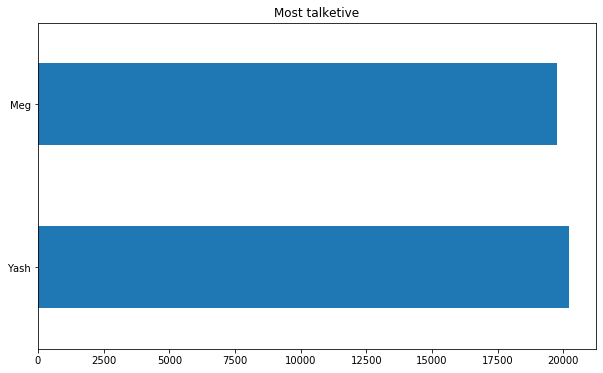

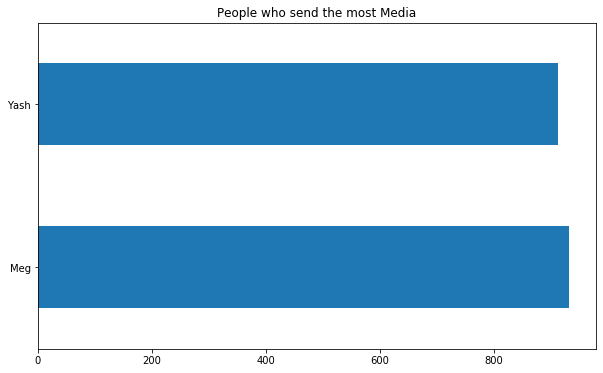

<Figure size 720x432 with 0 Axes>

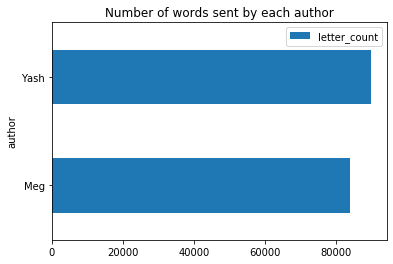

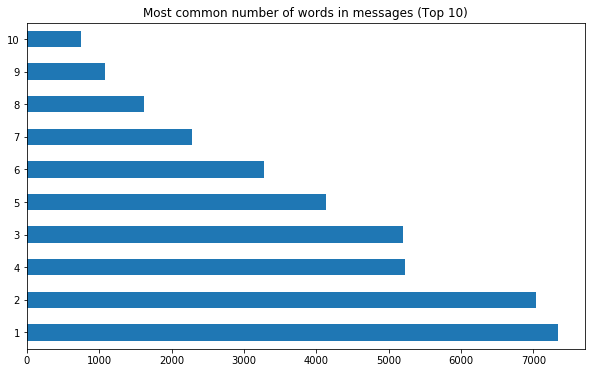

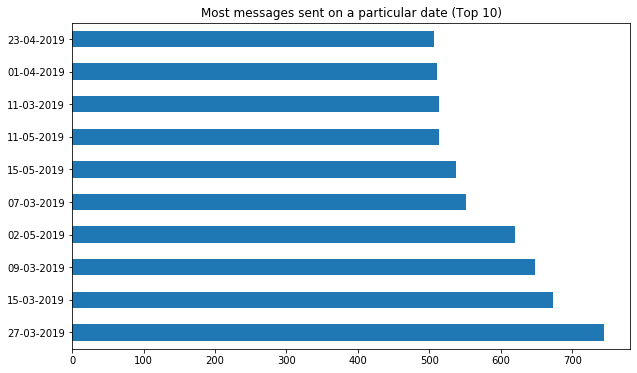

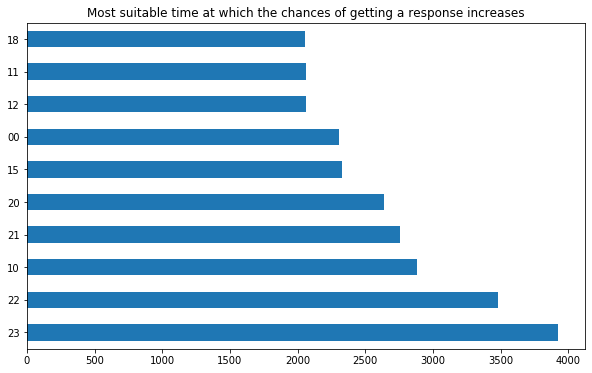

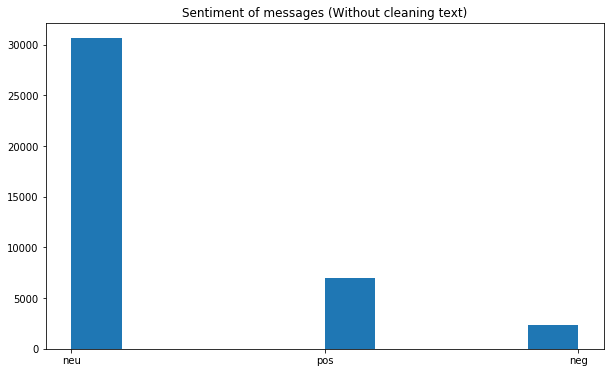

In [9]:
analysis = Visualize(chat_df).analyze()